<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/Weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect googledrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Weighted average

In [8]:
import pandas as pd

# 读取 intake24 数据
file_path = "/content/drive/MyDrive/UPF-HFI/NOVA classification/outcome/intake24_with_nova.xlsx"
intake_df = pd.read_excel(file_path)

# Step 0: 清洗 NOVA 字段为字符串，确保无空格
intake_df['NOVA'] = intake_df['NOVA'].astype(str).str.strip()

# Step 1: 创建是否为 UPF 的布尔变量（必须与字符串比较）
intake_df['is_upf'] = (intake_df['NOVA'] == '4').astype(int)

# Step 2: 乘以能量获得 upf_energy（单位 kcal）
intake_df['upf_energy'] = intake_df['is_upf'] * intake_df['Energykcal']

# Step 3: 打 weekday/weekend 标签
intake_df['day_type'] = intake_df['DAY'].str.lower().map(lambda x: 'weekend' if x in ['saturday', 'sunday'] else 'weekday')

# Step 4: 按 UserID + day_type 聚合总能量 和 upf 能量
agg_df = intake_df.groupby(['UserID_clean', 'day_type']).agg({
    'Energykcal': 'sum',
    'upf_energy': 'sum'
}).reset_index()

# Step 5: 透视表
pivot_df = agg_df.pivot(index='UserID_clean', columns='day_type', values=['Energykcal', 'upf_energy']).fillna(0)
pivot_df.columns = ['total_energy_weekday', 'total_energy_weekend', 'upf_energy_weekday', 'upf_energy_weekend']

# Step 6: 加权平均计算
pivot_df['weighted_total_energy'] = (pivot_df['total_energy_weekday'] * 5 + pivot_df['total_energy_weekend'] * 2) / 7
pivot_df['weighted_upf_energy'] = (pivot_df['upf_energy_weekday'] * 5 + pivot_df['upf_energy_weekend'] * 2) / 7
pivot_df['weighted_upf_pct'] = pivot_df['weighted_upf_energy'] / pivot_df['weighted_total_energy']

# Step 7: 保存
pivot_df.reset_index().to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_summary.xlsx", index=False)


# 计算每位儿童的 weighted UPF intensity score（加权UPF强度得分）

In [9]:
import pandas as pd

# 读取 intake24 含 NOVA 分类的数据（你之前的路径）
file_path = "/content/drive/MyDrive/UPF-HFI/NOVA classification/outcome/intake24_with_nova.xlsx"
intake_df = pd.read_excel(file_path)

# Step 1：清洗 NOVA 字段（保证是字符串，去空格）
intake_df['NOVA'] = intake_df['NOVA'].astype(str).str.strip()

# Step 2：构建 is_upf（加工强度评分）：NOVA1→0，NOVA2→1，NOVA3→2，NOVA4→3
nova_weight_map = {'1': 0, '2': 1, '3': 2, '4': 3}
intake_df['is_upf'] = intake_df['NOVA'].map(nova_weight_map).fillna(0)

# Step 3：乘以能量值，得到加工强度加权后的能量
intake_df['upf_energy'] = intake_df['is_upf'] * intake_df['Energykcal']

# Step 4：打 weekday/weekend 标签
intake_df['day_type'] = intake_df['DAY'].str.lower().map(lambda x: 'weekend' if x in ['saturday', 'sunday'] else 'weekday')

# Step 5：聚合能量
agg_df = intake_df.groupby(['UserID_clean', 'day_type']).agg({
    'Energykcal': 'sum',
    'upf_energy': 'sum'
}).reset_index()

# Step 6：透视成宽表
pivot_df = agg_df.pivot(index='UserID_clean', columns='day_type', values=['Energykcal', 'upf_energy']).fillna(0)
pivot_df.columns = ['total_energy_weekday', 'total_energy_weekend', 'upf_energy_weekday', 'upf_energy_weekend']
pivot_df = pivot_df.reset_index()

# Step 7：计算 weekday/weekend 加权平均
pivot_df['weighted_total_energy'] = (pivot_df['total_energy_weekday'] * 5 + pivot_df['total_energy_weekend'] * 2) / 7
pivot_df['weighted_upf_energy'] = (pivot_df['upf_energy_weekday'] * 5 + pivot_df['upf_energy_weekend'] * 2) / 7

# Step 8：最终得分 = weighted_upf_energy / weighted_total_energy
pivot_df['weighted_upf_score'] = pivot_df['weighted_upf_energy'] / pivot_df['weighted_total_energy']

# Step 9：保存输出（记得自己改文件路径）
pivot_df.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_score.xlsx", index=False)


# 选出一个对 HFI 敏感、区分度高、解释力强的因变量

In [12]:
#  第一步：读取 survey 表并创建 HFI 变量
import pandas as pd

# 读取 Survey 表（请改成你自己的路径）
survey_path = "/content/drive/MyDrive/UPF-HFI/Bradford_original data/4. SurveyMasterfile_clean.xlsx"
survey_df = pd.read_excel(survey_path)

# 创建 HFI 总分和是否不安全的标志变量
insecurity_cols = ['insecurity1', 'insecurity2', 'insecurity3','insecurity3a', 'insecurity4', 'insecurity5']
survey_df['HFI_score'] = survey_df[insecurity_cols].sum(axis=1)
survey_df['HFI'] = (survey_df['HFI_score'] >= 1).astype(int)

# 保留关键列
survey_df = survey_df[['UserID_clean', 'HFI']]


In [13]:
# 第二步：合并 UPF 表和 HFI 表
# 读取 UPF 表
upf_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_summary.xlsx"
upf_df = pd.read_excel(upf_path)

# 合并（确保 UserID_clean 的格式一致）
df = upf_df.merge(survey_df, on='UserID_clean', how='left')


In [17]:
print(pivot_df.columns)
print(df.columns)


Index(['UserID_clean', 'total_energy_weekday', 'total_energy_weekend',
       'upf_energy_weekday', 'upf_energy_weekend', 'weighted_total_energy',
       'weighted_upf_energy', 'weighted_upf_score'],
      dtype='object')
Index(['UserID_clean', 'total_energy_weekday', 'total_energy_weekend',
       'upf_energy_weekday', 'upf_energy_weekend', 'weighted_total_energy',
       'weighted_upf_energy', 'weighted_upf_pct', 'HFI'],
      dtype='object')


In [19]:
df['weighted_upf_score'] = pivot_df['weighted_upf_score']

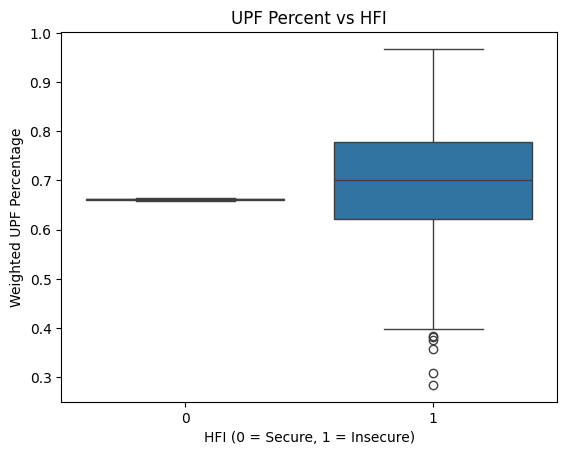

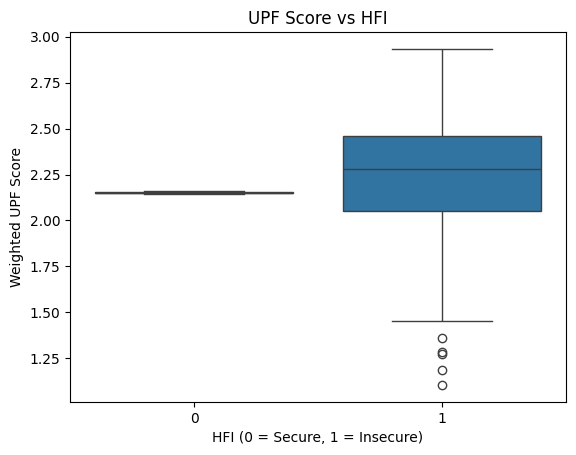

In [20]:
# 第三步：可视化对比 weighted_upf_pct 和 weighted_upf_score
import seaborn as sns
import matplotlib.pyplot as plt

# 比较 weighted_upf_pct
sns.boxplot(data=df, x='HFI', y='weighted_upf_pct')
plt.title('UPF Percent vs HFI')
plt.xlabel('HFI (0 = Secure, 1 = Insecure)')
plt.ylabel('Weighted UPF Percentage')
plt.show()


# 比较 weighted_upf_score
sns.boxplot(data=df, x='HFI', y='weighted_upf_score')
plt.title('UPF Score vs HFI')
plt.xlabel('HFI (0 = Secure, 1 = Insecure)')
plt.ylabel('Weighted UPF Score')
plt.show()


# 使用 t 检验比较两个指标在 HFI 组间的显著性差异

In [21]:
from scipy.stats import ttest_ind

# 拆分两组
secure = df[df['HFI'] == 0]
insecure = df[df['HFI'] == 1]

# 比较 weighted_upf_pct
t_stat_pct, p_val_pct = ttest _ind(secure['weighted_upf_pct'], insecure['weighted_upf_pct'], nan_policy='omit')
print(f"UPF Percentage: t={t_stat_pct:.3f}, p={p_val_pct:.4f}")

# 比较 weighted_upf_score
t_stat_score, p_val_score = ttest_ind(secure['weighted_upf_score'], insecure['weighted_upf_score'], nan_policy='omit')
print(f"UPF Score: t={t_stat_score:.3f}, p={p_val_score:.4f}")


UPF Percentage: t=-0.372, p=0.7098
UPF Score: t=-0.386, p=0.6995


看哪个 p-value 更小，说明哪个指标在组间的差异更显著。

# 计算 R² 看解释力更强的那个

In [22]:
import statsmodels.api as sm

# HFI → weighted_upf_pct
X1 = df[['HFI']]
y1 = df['weighted_upf_pct']
X1 = sm.add_constant(X1)
model1 = sm.OLS(y1, X1).fit()
print("UPF % R² =", model1.rsquared)

# HFI → weighted_upf_score
X2 = df[['HFI']]
y2 = df['weighted_upf_score']
X2 = sm.add_constant(X2)
model2 = sm.OLS(y2, X2).fit()
print("UPF Score R² =", model2.rsquared)


UPF % R² = 0.00042804550511121864
UPF Score R² = 0.0004604738305203915


哪个 R² 更高，说明哪个指标更能解释 HFI 的变异，作为回归模型的因变量更合适。